<h1>[ADA] <span class="label label-danger" style="font-size:36px">Data From the Web</span></h1><br><br>

<ul class="list-group" style="width:40%; float:left">
  <li class="list-group-item active"><b>Table of Contents</b></li>
  <li class="list-group-item">Part 0 : Getting Data from IS-Academia</li>
  <li class="list-group-item">Part 1 : Bachelor Data</li>
  <li class="list-group-item">Part 2 : Master Data</li>
  <li class="list-group-item">Bonus</li>
  <li class="list-group-item">Criticism</li>
</ul>


<ul class="list-group" style="width:40%; float:right">
  <li class="list-group-item active"><b>Team Members</b></li>
  <li class="list-group-item">Soufiane El Badraoui</li>
  <li class="list-group-item">Arnaud Miribel</li>
  <li class="list-group-item">Yu Yamashita</li>
</ul>

---

<h1 id="part0"> Part 0 : Getting Data from IS-Academia</h1>

In [1]:
from bs4 import BeautifulSoup
import pandas as pd 
import requests
from IPython.core.display import display, HTML

Using Postman with the Interceptor extension, we mimicate a manual browsing of the IS-A web form and button pressing in order to understand which requests are actually sent and which ones of them do matter.

We realize that only 1 matters and store its root URL. One example is as below : http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_x_GPS=-1&ww_i_reportModel=133685247&ww_i_reportModelXsl=133685270&ww_x_UNITE_ACAD=249847&ww_x_PERIODE_ACAD=213637754&ww_x_PERIODE_PEDAGO=942120&ww_x_HIVERETE=2936286

### Key-Value storage

We see in the URL that the actual form options are translated into values. So we would like to have a dictionary in order to store form options as keys and their values as values. That page actually stores all of the possible :

In [2]:
KEY_VALUE_URL = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247"

In [3]:
with requests.session() as s:
    response = s.get(KEY_VALUE_URL)
    
soup = BeautifulSoup(response.text, 'html.parser')
input_table = soup.find("table", attrs={"id": "format"})  # we want to find <table border="0" id="format">
option_table = soup.find("table", attrs={"id": "filtre"})  # we want to find <table border="0" id="filtre">
mapper = dict()

for inpt in input_table.findAll("input"):  
    try:
        mapper[inpt.text] = inpt["value"]  # <input type="radio" name="ww_i_reportModelXsl" value="133685270" checked>html
    except:
        pass
    
        
for option in option_table.findAll("option"):  # we want to find all options (e.g. <option value="942293">Architecture</option>)
    try:
        mapper[option.text] = int(option["value"])  # append to the dict (e.g. {'Architecture': 942293}) 
    except:  # if values are 'null' just ignore and pass
        pass 

In [4]:
mapper

{'2007-2008': 978181,
 '2008-2009': 978187,
 '2009-2010': 978195,
 '2010-2011': 39486325,
 '2011-2012': 123455150,
 '2012-2013': 123456101,
 '2013-2014': 213637754,
 '2014-2015': 213637922,
 '2015-2016': 213638028,
 '2016-2017': 355925344,
 'Architecture': 942293,
 'Bachelor semestre 1': 249108,
 'Bachelor semestre 2': 249114,
 'Bachelor semestre 3': 942155,
 'Bachelor semestre 4': 942163,
 'Bachelor semestre 5': 942120,
 'Bachelor semestre 5b': 2226768,
 'Bachelor semestre 6': 942175,
 'Bachelor semestre 6b': 2226785,
 'Chimie et génie chimique': 246696,
 'Cours de mathématiques spéciales': 943282,
 'EME (EPFL Middle East)': 637841336,
 'Génie civil': 942623,
 'Génie mécanique': 944263,
 'Génie électrique et électronique ': 943936,
 'Humanités digitales': 2054839157,
 'Informatique': 249847,
 'Ingénierie financière': 120623110,
 'Management de la technologie': 946882,
 'Master semestre 1': 2230106,
 'Master semestre 2': 942192,
 'Master semestre 3': 2230128,
 'Master semestre 4': 2230

In [5]:
def make_url(FORMAT, UNITE_ACAD, PERIODE_ACAD, PERIODE_PEDAGO, HIVERETE):
    return ("http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?"
            "ww_x_GPS=-1&"
            "ww_i_reportModel=133685247&"
            "ww_i_reportModelXsl={frmt}&"
            "ww_x_UNITE_ACAD={unite_acad}&"
            "ww_x_PERIODE_ACAD={periode_acad}&"
            "ww_x_PERIODE_PEDAGO={periode_pedago}&"
            "ww_x_HIVERETE={hiverete}").format(frmt=mapper[FORMAT],
                                               unite_acad=mapper[UNITE_ACAD],
                                               periode_acad=mapper[PERIODE_ACAD],
                                               periode_pedago=mapper[PERIODE_PEDAGO],
                                               hiverete=mapper[HIVERETE])

Now we have the URL, we also make a function that enables to parse the HTML we receive and plug the data into Pandas Dataframes

### Parsing HTML

In [6]:
def html_to_df(html_response):
    
    # put the HTML response into BeautifulSoup object
    soup = BeautifulSoup(html_response, 'html.parser')
    
    # find all data in HTML 
    table = soup.find("table")
    table_name = table.findAll("tr")[0].text
    table_columns = [t.text for t in table.findAll("tr")[1].findAll("th")]
    table_rows = table.findAll("tr")[3:]
    rows=[]
    for row in table_rows:
        rows.append([entries.text for entries in row.findAll("td")[:-1]])
        
    # put the data in a Pandas DataFrame
    table_df = pd.DataFrame(data=rows, columns=table_columns)
    
    # add year and semester fields
    table_df["Year"] = table_name.split(',')[1]
    table_df["Semester"] = table_name.split(',')[2].split('\n')[0]
    
    # reindexing
    table_df = table_df.reset_index()
    table_df = table_df.set_index(["Year","Semester","Nom Prénom"])
    
    return table_df

### Put all into one function

In [7]:
def get_df(FORMAT, UNITE_ACAD, PERIODE_ACAD, PERIODE_PEDAGO, HIVERETE):
    
    # make the correct URL for parameters
    url = make_url(FORMAT, UNITE_ACAD, PERIODE_ACAD, PERIODE_PEDAGO, HIVERETE)
    
    # do a GET to this URL
    with requests.session() as s:
        html_response = s.get(url).text
        
    # parse the HTML and put into a DF
    return html_to_df(html_response)

### Example for Informatique, 2013-2014, Bachelor semestre 5

In [8]:
get_df("html", "Informatique", "2013-2014", "Bachelor semestre 5", "Semestre d'automne").head(10)

index  \
Year       Semester             Nom Prénom                             
 2013-2014  Bachelor semestre 5 Alonso Seisdedos Florian           0   
                                Beaud Guillaume François Paul      1   
                                Benhamadi Yassine                  2   
                                Bennani-Smires Kamil               3   
                                Berney Léonard                     4   
                                Bottinelli Rémi                    5   
                                Bougacha Malik                     6   
                                Boullier Jocelyn                   7   
                                Bouquet Stéphane                   8   
                                Bovet Sidney                       9   

                                                               Civilité  \
Year       Semester             Nom Prénom                                
 2013-2014  Bachelor semestre 5 Alonso Seisdedos Florian       Monsieur   
                                Beaud Guillaume François Paul  Monsieur   
                                Benhamadi Yassine              Monsieur   
                                Bennani-Smires Kamil           Monsieur   
                                Berney Léonard                 Monsieur   
                                Bottinelli Rémi                Monsieur   
                                Bougacha Malik                 Monsieur   
                                Boullier Jocelyn               Monsieur   
                                Bouquet Stéphane               Monsieur   
                                Bovet Sidney                   Monsieur   

                                                              Orientation Bachelor  \
Year       Semester             Nom Prénom                                           
 2013-2014  Bachelor semestre 5 Alonso Seisdedos Florian                             
                                Beaud Guillaume François Paul                        
                                Benhamadi Yassine                                    
                                Bennani-Smires Kamil                                 
                                Berney Léonard                                       
                                Bottinelli Rémi                                      
                                Bougacha Malik                                       
                                Boullier Jocelyn                                     
                                Bouquet Stéphane                                     
                                Bovet Sidney                                         

                                                              Orientation Master  \
Year       Semester             Nom Prénom                                         
 2013-2014  Bachelor semestre 5 Alonso Seisdedos Florian                           
                                Beaud Guillaume François Paul                      
                                Benhamadi Yassine                                  
                                Bennani-Smires Kamil                               
                                Berney Léonard                                     
                                Bottinelli Rémi                                    
                                Bougacha Malik                                     
                                Boullier Jocelyn                                   
                                Bouquet Stéphane                                   
                                Bovet Sidney                                       

                                                              Spécialisation  \
Year       Semester             Nom Prénom                                     
 2013-2014  Bachelor semestre 5 Alonso Seisdedos Florian                       
               

So now we have useful functions to structure data from IS-Academia into well-prepared Pandas Dataframe.

<h1 id="part1">Part 1 - Bachelor Data</h1>

> 1. Obtain all the data for the Bachelor students, starting from 2007. Keep only the students for which you have an entry for both `Bachelor semestre 1` and `Bachelor semestre 6`. Compute how many months it took each student to go from the first to the sixth semester. Partition the data between male and female students, and compute the average -- is the difference in average statistically significant?

Now we want to answer question 1 : append all dataframes of Informatique we can find from 2007 to now.

In [9]:
def concat_dataframes(degree, n_potential_semesters):
    """
    degree : (str) "Bachelor" or "Master"
    n_potential_semesters : (int) 6 or 3
    """
    
    # make all parameters
    
    PERIODE_ACAD_RANGE = ["{year1}-{year2}".format(
            year1=y,
            year2=y+1) for y in range(2007,2016)]

    DEGREE_QUERY = degree + " semestre "
    PERIODE_PEGADO_RANGE = [DEGREE_QUERY + str(n) for n in range(1,n_potential_semesters+1)]
    HIVERETE_RANGE = ["Semestre d'automne", "Semestre de printemps"]

    PERIODE_RANGE = list(zip([DEGREE_QUERY + str(n) for n in range(1,n_potential_semesters+1,2)], 
                             ["Semestre d'automne"]*len(range(1,n_potential_semesters+1,2))))
    PERIODE_RANGE += list(zip([DEGREE_QUERY + str(n) for n in range(2,n_potential_semesters+1,2)], 
                              ["Semestre de printemps"]*len(range(2,n_potential_semesters+1,2))))
    
    # get all dataframes

    total = []  # list in which store temporary dataframes
    for periode_acad in PERIODE_ACAD_RANGE:
        for (periode_pedago, hiverete) in PERIODE_RANGE:
            df = get_df("html", "Informatique", periode_acad, periode_pedago, hiverete)
            total.append(df)  # append new temporary DF to list

    # concat all the dataframes
    return pd.concat(total)

In [10]:
bachelor_df = concat_dataframes("Bachelor", 6)

In [11]:
bachelor_df.head()

index  Civilité  \
Year       Semester             Nom Prénom                            
 2007-2008  Bachelor semestre 1 Aubelle Flavien         0  Monsieur   
                                Badoud Morgan           1  Monsieur   
                                Baeriswyl Jonathan      2  Monsieur   
                                Barroco Michael         3  Monsieur   
                                Belfis Nicolas          4  Monsieur   

                                                   Orientation Bachelor  \
Year       Semester             Nom Prénom                                
 2007-2008  Bachelor semestre 1 Aubelle Flavien                           
                                Badoud Morgan                             
                                Baeriswyl Jonathan                        
                                Barroco Michael                           
                                Belfis Nicolas                            

                                                   Orientation Master  \
Year       Semester             Nom Prénom                              
 2007-2008  Bachelor semestre 1 Aubelle Flavien                         
                                Badoud Morgan                           
                                Baeriswyl Jonathan                      
                                Barroco Michael                         
                                Belfis Nicolas                          

                                                   Spécialisation  \
Year       Semester             Nom Prénom                          
 2007-2008  Bachelor semestre 1 Aubelle Flavien                     
                                Badoud Morgan                       
                                Baeriswyl Jonathan                  
                                Barroco Michael                     
                                Belfis Nicolas                      

                                                   Filière opt. Mineur  \
Year       Semester             Nom Prénom                               
 2007-2008  Bachelor semestre 1 Aubelle Flavien                          
                                Badoud Morgan                            
                                Baeriswyl Jonathan                       
                                Barroco Michael                          
                                Belfis Nicolas                           

                                                     Statut Type Echange  \
Year       Semester             Nom Prénom                                 
 2007-2008  Bachelor semestre 1 Aubelle Flavien     Présent                
                                Badoud Morgan       Présent                
                                Baeriswyl Jonathan  Présent                
                                Barroco Michael     Présent                
                                Belfis Nicolas      Présent                

                                                   Ecole Echange No Sciper  
Year       Semester             Nom Prénom                                  
 2007-2008  Bachelor semestre 1 Aubelle Flavien                     174905  
                                Badoud Morgan                       173922  
                                Baeriswyl Jonathan                  179406  
                                Barroco Michael                     179428  
                                Belfis Nicolas                      179324

Now we want to filter out scipers that didn't attend both Bachelor semester 1 and Bachelor semester 2. We fill the matching scipers in a new dataframe named `filtered_bachelor_df`

In [12]:
filtered_scipers = []

for sciper in list(set(bachelor_df["No Sciper"])):
    
    temp_df = bachelor_df[bachelor_df["No Sciper"] == sciper]
    list_sem = temp_df.index.get_level_values("Semester")
    
    cond1 = ' Bachelor semestre 1' in list_sem
    cond2 = ' Bachelor semestre 6' in list_sem
    
    if cond1 == True and cond2 == True:
        filtered_scipers.append(temp_df)
    
filtered_bachelor_df = pd.concat(filtered_scipers)

# Re-indexing
filtered_bachelor_df = filtered_bachelor_df.reset_index()
filtered_bachelor_df = filtered_bachelor_df.set_index(["Nom Prénom","No Sciper", "Year", "Semester"])

In [13]:
filtered_bachelor_df.head()

index  Civilité  \
Nom Prénom No Sciper Year       Semester                                
Girod Luc  192555     2011-2012  Bachelor semestre 1     59  Monsieur   
                                 Bachelor semestre 2     46  Monsieur   
                      2012-2013  Bachelor semestre 3     26  Monsieur   
                                 Bachelor semestre 4     26  Monsieur   
                      2013-2014  Bachelor semestre 5     43  Monsieur   

                                                     Orientation Bachelor  \
Nom Prénom No Sciper Year       Semester                                    
Girod Luc  192555     2011-2012  Bachelor semestre 1                        
                                 Bachelor semestre 2                        
                      2012-2013  Bachelor semestre 3                        
                                 Bachelor semestre 4                        
                      2013-2014  Bachelor semestre 5                        

                                                     Orientation Master  \
Nom Prénom No Sciper Year       Semester                                  
Girod Luc  192555     2011-2012  Bachelor semestre 1                      
                                 Bachelor semestre 2                      
                      2012-2013  Bachelor semestre 3                      
                                 Bachelor semestre 4                      
                      2013-2014  Bachelor semestre 5                      

                                                     Spécialisation  \
Nom Prénom No Sciper Year       Semester                              
Girod Luc  192555     2011-2012  Bachelor semestre 1                  
                                 Bachelor semestre 2                  
                      2012-2013  Bachelor semestre 3                  
                                 Bachelor semestre 4                  
                      2013-2014  Bachelor semestre 5                  

                                                     Filière opt. Mineur  \
Nom Prénom No Sciper Year       Semester                                   
Girod Luc  192555     2011-2012  Bachelor semestre 1                       
                                 Bachelor semestre 2                       
                      2012-2013  Bachelor semestre 3                       
                                 Bachelor semestre 4                       
                      2013-2014  Bachelor semestre 5                       

                                                       Statut Type Echange  \
Nom Prénom No Sciper Year       Semester                                     
Girod Luc  192555     2011-2012  Bachelor semestre 1  Présent                
                                 Bachelor semestre 2  Présent                
                      2012-2013  Bachelor semestre 3  Présent                
                                 Bachelor semestre 4  Présent                
                      2013-2014  Bachelor semestre 5  Présent                

                                                     Ecole Echange  
Nom Prénom No Sciper Year       Semester                            
Girod Luc  192555     2011-2012  Bachelor semestre 1                
                                 Bachelor semestre 2                
                      2012-2013  Bachelor semestre 3                
                                 Bachelor semestre 4                
                      2013-2014  Bachelor semestre 5

Now let's check how many distinct students who started the bachelor at EPFL and finished it (b/w 2007 and 2016), we call that `num_bachelor_graduates`

In [16]:
filtered_bachelor_scipers = filtered_bachelor_df.index.get_level_values('No Sciper').drop_duplicates()
num_bachelor_graduates = filtered_bachelor_scipers.shape[0]
print(num_bachelor_graduates, " Bachelor students graduated")

372  Bachelor students graduated


We know that this result may vary depending on groups assumptions, but we consider only students that completed both Semester 1 and Semester 6 in EPFL (as strictly said in the question). That has two drawbacks :

- it excludes students that entered EPFL using "Passerelles" (arriving directly in 2nd year) 
- it also excludes students that did change section during their Bachelor. 

We highlight this limitation by giving an example, Christian Mouchet, that arrived in Computer Science only in 2nd year of Bachelor. It is not counted in our calculus because it doesn't fill the criteria of the question but that could be discussed as he has been a Bachelor Graduate in CS anyway.

In [17]:
mouchet = bachelor_df[bachelor_df["No Sciper"] == "217453"]
mouchet = mouchet.reset_index()
mouchet = mouchet.set_index(["Civilité","Nom Prénom", "Year", "Semester"])
mouchet

index  \
Civilité Nom Prénom                Year       Semester                      
Monsieur Mouchet Christian Vincent  2012-2013  Bachelor semestre 3     48   
                                               Bachelor semestre 4     44   
                                    2013-2014  Bachelor semestre 5     68   
                                               Bachelor semestre 6     56   

                                                                   Orientation Bachelor  \
Civilité Nom Prénom                Year       Semester                                    
Monsieur Mouchet Christian Vincent  2012-2013  Bachelor semestre 3                        
                                               Bachelor semestre 4                        
                                    2013-2014  Bachelor semestre 5                        
                                               Bachelor semestre 6                        

                                                                   Orientation Master  \
Civilité Nom Prénom                Year       Semester                                  
Monsieur Mouchet Christian Vincent  2012-2013  Bachelor semestre 3                      
                                               Bachelor semestre 4                      
                                    2013-2014  Bachelor semestre 5                      
                                               Bachelor semestre 6                      

                                                                   Spécialisation  \
Civilité Nom Prénom                Year       Semester                              
Monsieur Mouchet Christian Vincent  2012-2013  Bachelor semestre 3                  
                                               Bachelor semestre 4                  
                                    2013-2014  Bachelor semestre 5                  
                                               Bachelor semestre 6                  

                                                                   Filière opt.  \
Civilité Nom Prénom                Year       Semester                            
Monsieur Mouchet Christian Vincent  2012-2013  Bachelor semestre 3                
                                               Bachelor semestre 4                
                                    2013-2014  Bachelor semestre 5                
                                               Bachelor semestre 6                

                                                                   Mineur  \
Civilité Nom Prénom                Year       Semester                      
Monsieur Mouchet Christian Vincent  2012-2013  Bachelor semestre 3          
                                               Bachelor semestre 4          
                                    2013-2014  Bachelor semestre 5          
                                               Bachelor semestre 6          

                                                                     Statut  \
Civilité Nom Prénom                Year       Semester                        
Monsieur Mouchet Christian Vincent  2012-2013  Bachelor semestre 3  Attente   
                                               Bachelor semestre 4  Présent   
                                    2013-2014  Bachelor semestre 5  Présent   
                                               Bachelor semestre 6  Présent   

                                                                   Type Echange  \
Civilité Nom Prénom                Year       Semester                            
Monsieur Mouchet Christian Vincent  2012-2013  Bachelor semestre 3                
                                               Bachelor semestre 4                
                                    2013-2014  Bachelor semestre 5                
                                               Bachelor semestre 6                

                                                                   Ecole Ech

We want to estimate the average duration for students to reach a Bachelor Degree at EPFL in Computer Science. By assuming it takes 6 months per semester, we do as follow : 

In [18]:
def compute_duration(df, sciper_index):
    from collections import Counter
    df_scipers = df.index.get_level_values('No Sciper')
    cnt = Counter(df_scipers)
    
    name_index = df.index.get_level_values('Nom Prénom')
    name_index = name_index.drop_duplicates()

    duration_df = pd.DataFrame(sciper_index,index=name_index)
    duration_df['Duration (Months)'] = [cnt[scp]*6 for scp in sciper_index]  # tranform semesters into months 
    return duration_df
    

In [19]:
duration_bachelor_df = compute_duration(filtered_bachelor_df, filtered_bachelor_scipers)

In [20]:
duration_bachelor_df.head()

,No Sciper,Duration (Months)
Nom Prénom,,
Girod Luc,192555,60
Zablotchi Mihail Igor,192870,36
Montero Hernandez Aimée,221053,36
Zoller Roman,178682,36
Kuenlin Quentin,234033,36


In [21]:
duration_bachelor_df['Duration (Months)'].describe()

count    372.000000
mean      42.274194
std        8.910461
min       18.000000
25%       36.000000
50%       36.000000
75%       48.000000
max       72.000000
Name: Duration (Months), dtype: float64

We can see that on the 372 students we kept that had entries both for Bachelor semestre 1 and Bachelor semestre 6, the mean number of semesters to reach the degree is of 7.045 which means __42.27 months__. There is a maximum for 72 months (6 years). And a minimum for 3 semesters (18 months) : how is that possible ?


In [22]:
target_sciper = duration_bachelor_df[duration_bachelor_df["Duration (Months)"]==18]["No Sciper"][0]
bachelor_df[bachelor_df["No Sciper"] == target_sciper]

index  Civilité  \
Year       Semester             Nom Prénom                                   
 2013-2014  Bachelor semestre 1 Alfonso Peterssen Alfonso      0  Monsieur   
 2015-2016  Bachelor semestre 5 Alfonso Peterssen Alfonso      0  Monsieur   
            Bachelor semestre 6 Alfonso Peterssen Alfonso      0  Monsieur   

                                                          Orientation Bachelor  \
Year       Semester             Nom Prénom                                       
 2013-2014  Bachelor semestre 1 Alfonso Peterssen Alfonso                        
 2015-2016  Bachelor semestre 5 Alfonso Peterssen Alfonso                        
            Bachelor semestre 6 Alfonso Peterssen Alfonso                        

                                                          Orientation Master  \
Year       Semester             Nom Prénom                                     
 2013-2014  Bachelor semestre 1 Alfonso Peterssen Alfonso                      
 2015-2016  Bachelor semestre 5 Alfonso Peterssen Alfonso                      
            Bachelor semestre 6 Alfonso Peterssen Alfonso                      

                                                          Spécialisation  \
Year       Semester             Nom Prénom                                 
 2013-2014  Bachelor semestre 1 Alfonso Peterssen Alfonso                  
 2015-2016  Bachelor semestre 5 Alfonso Peterssen Alfonso                  
            Bachelor semestre 6 Alfonso Peterssen Alfonso                  

                                                                   Filière opt.  \
Year       Semester             Nom Prénom                                        
 2013-2014  Bachelor semestre 1 Alfonso Peterssen Alfonso                         
 2015-2016  Bachelor semestre 5 Alfonso Peterssen Alfonso  6 - Visual computing   
            Bachelor semestre 6 Alfonso Peterssen Alfonso  6 - Visual computing   

                                                          Mineur   Statut  \
Year       Semester             Nom Prénom                                  
 2013-2014  Bachelor semestre 1 Alfonso Peterssen Alfonso         Présent   
 2015-2016  Bachelor semestre 5 Alfonso Peterssen Alfonso         Présent   
            Bachelor semestre 6 Alfonso Peterssen Alfonso         Présent   

                                                          Type Echange  \
Year       Semester             Nom Prénom                               
 2013-2014  Bachelor semestre 1 Alfonso Peterssen Alfonso                
 2015-2016  Bachelor semestre 5 Alfonso Peterssen Alfonso                
            Bachelor semestre 6 Alfonso Peterssen Alfonso                

                                                          Ecole Echange  \
Year       Semester             Nom Prénom                                
 2013-2014  Bachelor semestre 1 Alfonso Peterssen Alfonso                 
 2015-2016  Bachelor semestre 5 Alfonso Peterssen Alfonso                 
            Bachelor semestre 6 Alfonso Peterssen Alfonso                 

                                                          No Sciper  
Year       Semester             Nom Prénom                           
 2013-2014  Bachelor semestre 1 Alfonso Peterssen Alfonso    228219  
 2015-2016  Bachelor semestre 5 Alfonso Peterssen Alfonso    228219  
            Bachelor semestre 6 Alfonso Peterssen Alfonso    228219

Alfonso apparently did go from BA1 directly to BA5, BA6, it's worth asking the recipe! Or is there only missing data in 2014-2015 ? Weird.

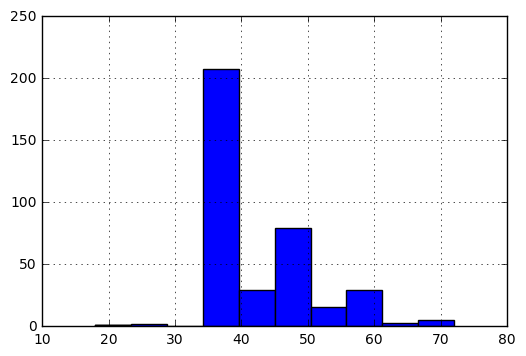

In [23]:
%matplotlib inline
duration_bachelor_df['Duration (Months)'].hist()

In [24]:
filtered_bachelor_df.head()

index  Civilité  \
Nom Prénom No Sciper Year       Semester                                
Girod Luc  192555     2011-2012  Bachelor semestre 1     59  Monsieur   
                                 Bachelor semestre 2     46  Monsieur   
                      2012-2013  Bachelor semestre 3     26  Monsieur   
                                 Bachelor semestre 4     26  Monsieur   
                      2013-2014  Bachelor semestre 5     43  Monsieur   

                                                     Orientation Bachelor  \
Nom Prénom No Sciper Year       Semester                                    
Girod Luc  192555     2011-2012  Bachelor semestre 1                        
                                 Bachelor semestre 2                        
                      2012-2013  Bachelor semestre 3                        
                                 Bachelor semestre 4                        
                      2013-2014  Bachelor semestre 5                        

                                                     Orientation Master  \
Nom Prénom No Sciper Year       Semester                                  
Girod Luc  192555     2011-2012  Bachelor semestre 1                      
                                 Bachelor semestre 2                      
                      2012-2013  Bachelor semestre 3                      
                                 Bachelor semestre 4                      
                      2013-2014  Bachelor semestre 5                      

                                                     Spécialisation  \
Nom Prénom No Sciper Year       Semester                              
Girod Luc  192555     2011-2012  Bachelor semestre 1                  
                                 Bachelor semestre 2                  
                      2012-2013  Bachelor semestre 3                  
                                 Bachelor semestre 4                  
                      2013-2014  Bachelor semestre 5                  

                                                     Filière opt. Mineur  \
Nom Prénom No Sciper Year       Semester                                   
Girod Luc  192555     2011-2012  Bachelor semestre 1                       
                                 Bachelor semestre 2                       
                      2012-2013  Bachelor semestre 3                       
                                 Bachelor semestre 4                       
                      2013-2014  Bachelor semestre 5                       

                                                       Statut Type Echange  \
Nom Prénom No Sciper Year       Semester                                     
Girod Luc  192555     2011-2012  Bachelor semestre 1  Présent                
                                 Bachelor semestre 2  Présent                
                      2012-2013  Bachelor semestre 3  Présent                
                                 Bachelor semestre 4  Présent                
                      2013-2014  Bachelor semestre 5  Présent                

                                                     Ecole Echange  
Nom Prénom No Sciper Year       Semester                            
Girod Luc  192555     2011-2012  Bachelor semestre 1                
                                 Bachelor semestre 2                
                      2012-2013  Bachelor semestre 3                
                                 Bachelor semestre 4                
                      2013-2014  Bachelor semestre 5

In [72]:
def df_join(df, duration_df, attribute):
    right = df.reset_index()
    right = right.set_index(["No Sciper"]).drop_duplicates()
    left = duration_df.reset_index()
    left = left.set_index(["No Sciper"])
    join = pd.merge(left, right, right_index=True, left_index=True)

    join = join.reset_index()
    join = join[["No Sciper", attribute, "Duration (Months)", "Year"]].drop_duplicates()
    return join

In [59]:
df_join(df=bachelor_df, duration_df=duration_bachelor_df, attribute="Civilité").groupby("Civilité").mean()

,Duration (Months)
Civilité,
Madame,39.857143
Monsieur,42.470930


Apparently, in average, __women are faster than men__ : 39.8 months versus 42.5 months! Now this is only roughly 10% difference, and classes are highly unbalanced (344 men versus 28 women), so it is maybe not that statistically significant. 

# Part 3 - Master Data

> 2. Perform a similar operation to what described above, this time for Master students. Notice that this data is more tricky, as there are
many missing records in the IS-Academia database. Therefore, try to guess __how much time a master student spent at EPFL__ by at least checking
the distance in months between `Master semestre 1` and `Master semestre 2`. If the `Mineur` field is *not* empty, the student should also
appear registered in `Master semestre 3`. Last but not the least, don't forget to check if the student has an entry also in the `Projet Master`
tables. Once you can handle well this data, compute the "average stay at EPFL" for master students. Now __extract all the students with a 
`Spécialisation` and compute the "average stay" per each category of that attribute__ -- compared to the general average, can you find any
specialization for which the difference in average is statistically significant?

First we get the data

In [27]:
master_df = concat_dataframes(degree="Master", n_potential_semesters=3)

In [28]:
master_df.describe()

,index
count,2431.000000
mean,51.854792
std,37.810420
min,0.000000
25%,22.000000
50%,45.000000
75%,74.000000
max,194.000000


In [29]:
master_df.head()

index  Civilité  \
Year       Semester           Nom Prénom                            
 2007-2008  Master semestre 1 Agarwal Megha           0    Madame   
                              Anagnostaras David      1  Monsieur   
                              Auroux Damien           2  Monsieur   
                              Awalebo Joseph          3  Monsieur   
                              Balet Ken               4  Monsieur   

                                                 Orientation Bachelor  \
Year       Semester           Nom Prénom                                
 2007-2008  Master semestre 1 Agarwal Megha                             
                              Anagnostaras David                        
                              Auroux Damien                             
                              Awalebo Joseph                            
                              Balet Ken                                 

                                                 Orientation Master  \
Year       Semester           Nom Prénom                              
 2007-2008  Master semestre 1 Agarwal Megha                           
                              Anagnostaras David                      
                              Auroux Damien                           
                              Awalebo Joseph                          
                              Balet Ken                               

                                                 Spécialisation Filière opt.  \
Year       Semester           Nom Prénom                                       
 2007-2008  Master semestre 1 Agarwal Megha                                    
                              Anagnostaras David                               
                              Auroux Damien                                    
                              Awalebo Joseph                                   
                              Balet Ken                                        

                                                 Mineur   Statut Type Echange  \
Year       Semester           Nom Prénom                                        
 2007-2008  Master semestre 1 Agarwal Megha              Présent                
                              Anagnostaras David         Présent                
                              Auroux Damien              Présent                
                              Awalebo Joseph             Présent                
                              Balet Ken                  Présent                

                                                 Ecole Echange No Sciper  
Year       Semester           Nom Prénom                                  
 2007-2008  Master semestre 1 Agarwal Megha                       180027  
                              Anagnostaras David                  152232  
                              Auroux Damien                       177395  
                              Awalebo Joseph                      161970  
                              Balet Ken                           166258

Now we want to filter out students that did not graduate from EPFL.
The problem is that the Computer Science Master degree can be made in two ways: 

- Option 1 : 90 ECTS, 2 semesters, without Specialization or Minor + Master Project
- Option 2 : 120 ECTS, 3 semesters, within a Specialization or Minor + Master Project

One could directly argue that regardless the option, the necessary and sufficient condition would be to complete a Master Project, but the data for Master Projects is terribly sparse (2015-2016 Fall : only 2 students registered for a Master Project.. huh) so we can not rely on it and will do approximations with the following assumptions :  

- Condition 1 : You need __more__ than 1 semester to graduate
- Condition 2 : If you did only 2 semesters you __should not__ have the field "Specialization" or "Minor".
- A semester with status "Stage" counts as a normal semester (internship is mandatory for the Master, especially for a student that wants to do his Master Project in laboratory)

Let's filter our dataframe given the conditions above :

In [40]:
filtered_scipers = []

for sciper in list(set(master_df["No Sciper"])):
    
    temp_df = master_df[master_df["No Sciper"] == sciper]
    list_sem = temp_df.index.get_level_values("Semester")
    
    cond1 = len(list_sem) > 1
    cond2 = (len(list_sem) == 2 and 
            ((len(temp_df["Mineur"]) != 0 or len(temp_df["Spécialisation"]) != 0)))
    
    if cond1 and not cond2:
        filtered_scipers.append(temp_df)
    
filtered_master_df = pd.concat(filtered_scipers)

# Re-indexing
filtered_master_df = filtered_master_df.reset_index()
filtered_master_df = filtered_master_df.set_index(["Nom Prénom","No Sciper", "Year", "Semester"])

In [31]:
filtered_master_df.head(10)

index  \
Nom Prénom                   No Sciper Year       Semester                    
Zablotchi Mihail Igor        192870     2012-2013  Master semestre 1     85   
                                                   Master semestre 2    123   
                                        2013-2014  Master semestre 3     72   
                                                   Master semestre 2    135   
Guliyev Khayyam Mubariz Oglu 247455     2014-2015  Master semestre 1     44   
                                                   Master semestre 2     67   
                                        2015-2016  Master semestre 3     39   
                                                   Master semestre 2     73   
Zoller Roman                 178682     2010-2011  Master semestre 1     94   
                                                   Master semestre 2    107   

                                                                      Civilité  \
Nom Prénom                   No Sciper Year       Semester                       
Zablotchi Mihail Igor        192870     2012-2013  Master semestre 1  Monsieur   
                                                   Master semestre 2  Monsieur   
                                        2013-2014  Master semestre 3  Monsieur   
                                                   Master semestre 2  Monsieur   
Guliyev Khayyam Mubariz Oglu 247455     2014-2015  Master semestre 1  Monsieur   
                                                   Master semestre 2  Monsieur   
                                        2015-2016  Master semestre 3  Monsieur   
                                                   Master semestre 2  Monsieur   
Zoller Roman                 178682     2010-2011  Master semestre 1  Monsieur   
                                                   Master semestre 2  Monsieur   

                                                                     Orientation Bachelor  \
Nom Prénom                   No Sciper Year       Semester                                  
Zablotchi Mihail Igor        192870     2012-2013  Master semestre 1                        
                                                   Master semestre 2                        
                                        2013-2014  Master semestre 3                        
                                                   Master semestre 2                        
Guliyev Khayyam Mubariz Oglu 247455     2014-2015  Master semestre 1                        
                                                   Master semestre 2                        
                                        2015-2016  Master semestre 3                        
                                                   Master semestre 2                        
Zoller Roman                 178682     2010-2011  Master semestre 1                        
                                                   Master semestre 2                        

                                                                     Orientation Master  \
Nom Prénom                   No Sciper Year       Semester                                
Zablotchi Mihail Igor        192870     2012-2013  Master semestre 1                      
                                                   Master semestre 2                      
                                        2013-2014  Master semestre 3                      
                                                   Master semestre 2                      
Guliyev Khayyam Mubariz Oglu 247455     2014-2015  Master semestre 1                      
                                                   Master semestre 2                      
                                        2015-2016  Master semestre 3                      
                                                   Master semestre 2                      
Zoller Roman                 178682     2010-2011  Master semestre 1                      
                  

Let's now check how many distinct students started the Master at EPFL and finished it (b/w 2007 and 2016)

In [32]:
filtered_master_scipers = filtered_master_df.index.get_level_values('No Sciper').drop_duplicates()
num_master_graduates = filtered_master_scipers.shape[0]
print(num_master_graduates, " Master students graduated")

510  Master students graduated


In [33]:
duration_master_df = compute_duration(filtered_master_df, filtered_master_scipers)

In [34]:
print("Average number of months is ", duration_master_df.mean()[1])

Average number of months is  21.5294117647


To have more granularity we can plot the histogram of values

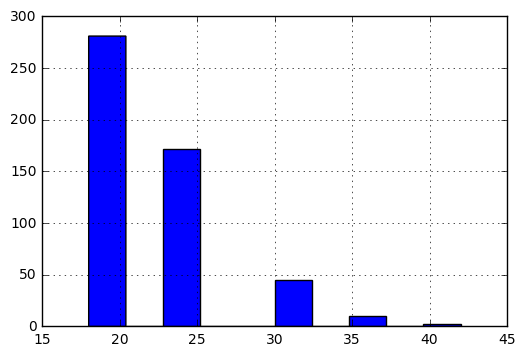

In [35]:
%matplotlib inline
duration_master_df['Duration (Months)'].hist()

Now if we filter by specialization, is the duration statistically significantly different from one specialization to the other ?

In [60]:
by_specialization = df_join(df=master_df, duration_df=duration_master_df, attribute="Spécialisation").groupby("Spécialisation")
by_specialization.mean()

,Duration (Months)
Spécialisation,
,21.449024
Biocomputing,24.000000
Computer Engineering - SP,21.176471
Foundations of Software,22.965517
Information Security - SP,24.000000
Internet computing,22.642857
Service science,21.600000
"Signals, Images and Interfaces",24.692308
Software Systems,21.600000


It doesn't seems like there is a big difference given the specialization..


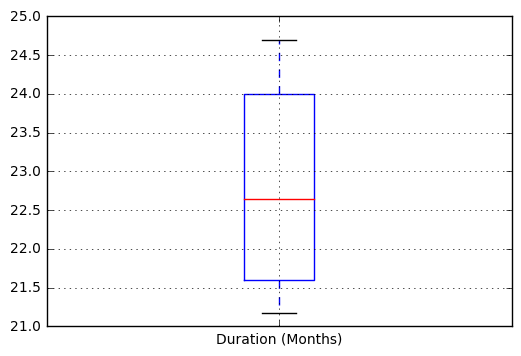

In [37]:
by_specialization.mean().boxplot(return_type='axes')

Now if we look with more granularity, we can see that the distribution within a specialization is sometimes very different.

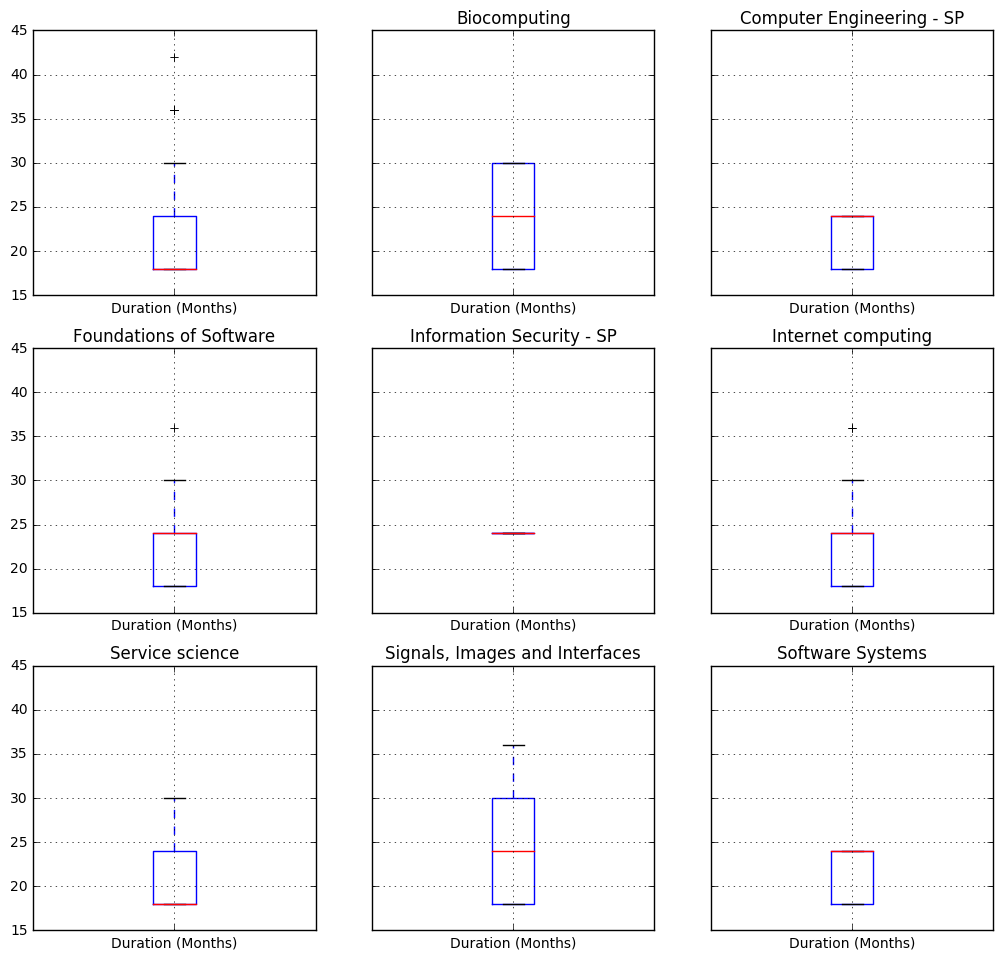

In [38]:
by_specialization.boxplot(return_type='axes', figsize=(12,12));

# Bonus

In [55]:
import numpy as np
from scipy import stats

> BONUS: perform the gender-based study also on the Master students, as explained in 1. Use scatterplots to visually identify changes over time. Plot males and females with different colors -- can you spot different trends that match the results of your statistical tests?

We choose Two-Sample T-Test to investigate whether the means of two independent data samples differ from one another,
because we have two independent data samples but we don't know if they have the same variance.
The null hypothesis is that the average number of months spent in the Bachelor for male and female is the same

In [73]:
by_gender = df_join(df=master_df.reset_index(), duration_df=duration_master_df.reset_index(), attribute="Civilité")

men = np.array(by_gender[by_gender.Civilité == 'Monsieur']['Duration (Months)'])
women = np.array(by_gender[by_gender.Civilité == 'Madame']['Duration (Months)'])
stats.ttest_ind(a= men,
                b= women,
                equal_var=False)

Ttest_indResult(statistic=-1.4308919894205816, pvalue=0.15417203128684107)

The test yields a p-value of 0.43397415708836795, which means there is a 43% chance we'd see sample data this far apart if the two groups would fail to reject the null hypothesis, since the p-value is greater than the corresponding significance level of 10%(0,1), we can't reject the null hypothesis 

About yearly evolution of per gender durations : 

In [110]:
by_year_and_gender = by_gender.groupby(["Year", "Civilité"]).mean().to_dict()

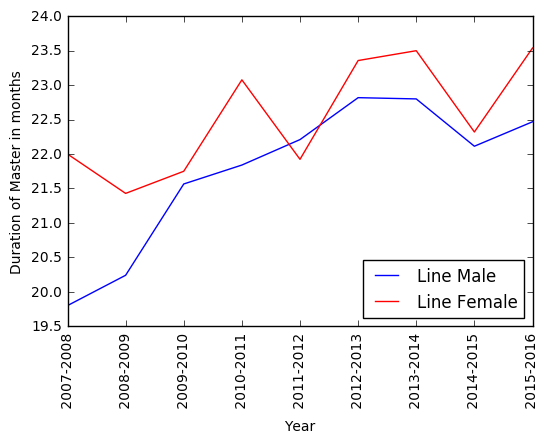

In [111]:
import matplotlib.pyplot as plt

years = [" {year1}-{year2}".format(
            year1=y,
            year2=y+1) for y in range(2007,2016)]
n_male = [by_year_and_gender["Duration (Months)"][(y, "Monsieur")] for y in years]
n_female = [by_year_and_gender["Duration (Months)"][(y, "Madame")] for y in years]

x = [int(y.split("-")[0].strip(" ")) for y in years]
line_male, = plt.plot(x,n_male, 'b', label="Line Male")
line_female, = plt.plot(x,n_female, 'r', label="Line Female")
plt.xlabel("Year")
plt.ylabel("Duration of Master in months")
plt.xticks(x, years, rotation='vertical')
plt.legend(handles=[line_male, line_female], loc=4)

There is a clear trend of rise for Master duration when it comes to Men... As we said earlier, it is hard to draw conclusions on such data for Women because the classes are really unbalanced. One could definitely say that for men, the trend highlights that the Master gets harder so longer ?

# Self-criticism

We checked online for official results, and for data from 2006 to 2015 the official aggregate should be 666

<img src="official_report.png">

So at some point our assumptions must have been different from that of the official statistician (we under-estimate the number of students). But at least now the pipeline is done and further discussions / tradeoffs would probably enable to come with precise rules and filters to match the above results.